In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

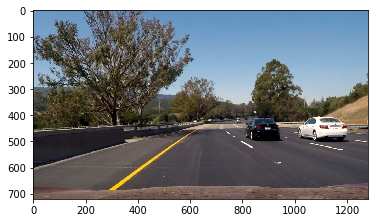

In [4]:
image = mpimg.imread('test6.jpg')
plt.imshow(image)

Convert to grayscale, and apply a threshold that identifies the lines:

In [5]:
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

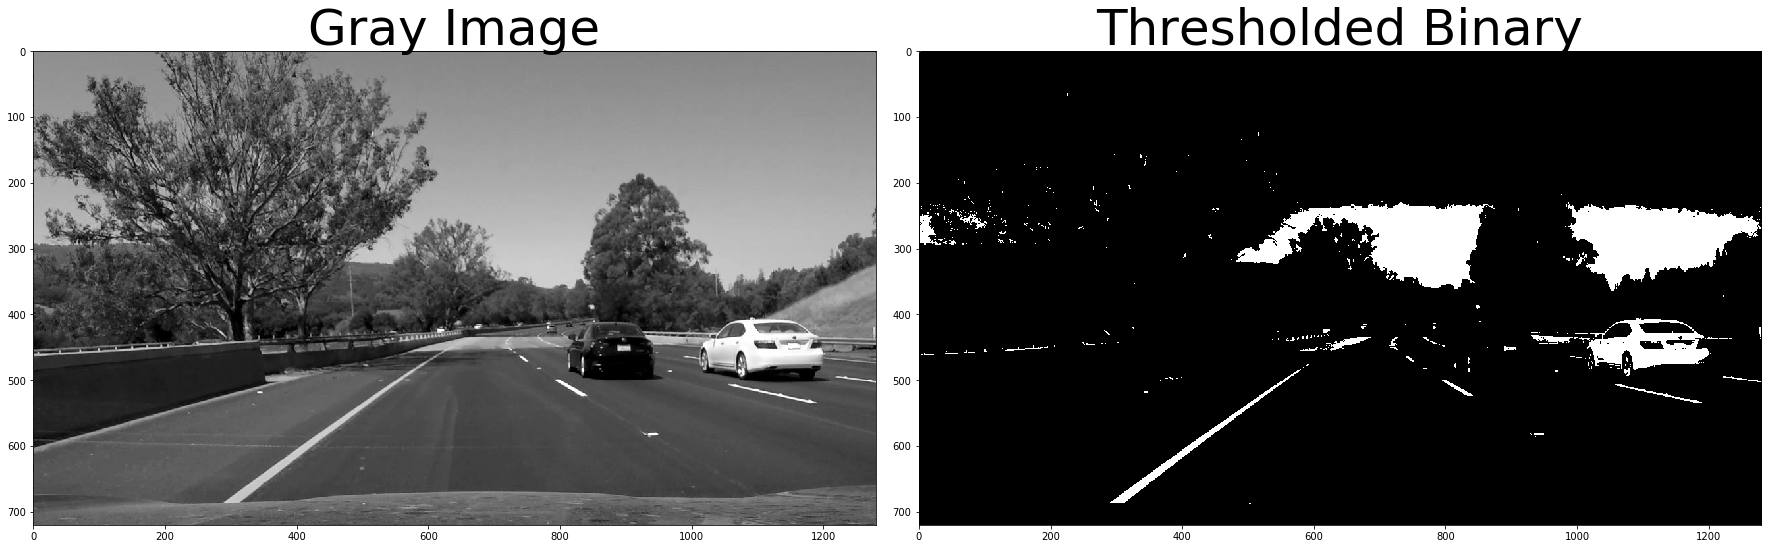

In [6]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('Gray Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### RGB color channels

In [8]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
R.shape, G.shape, B.shape

((720, 1280), (720, 1280), (720, 1280))

Text(0.5,1,'B Image')

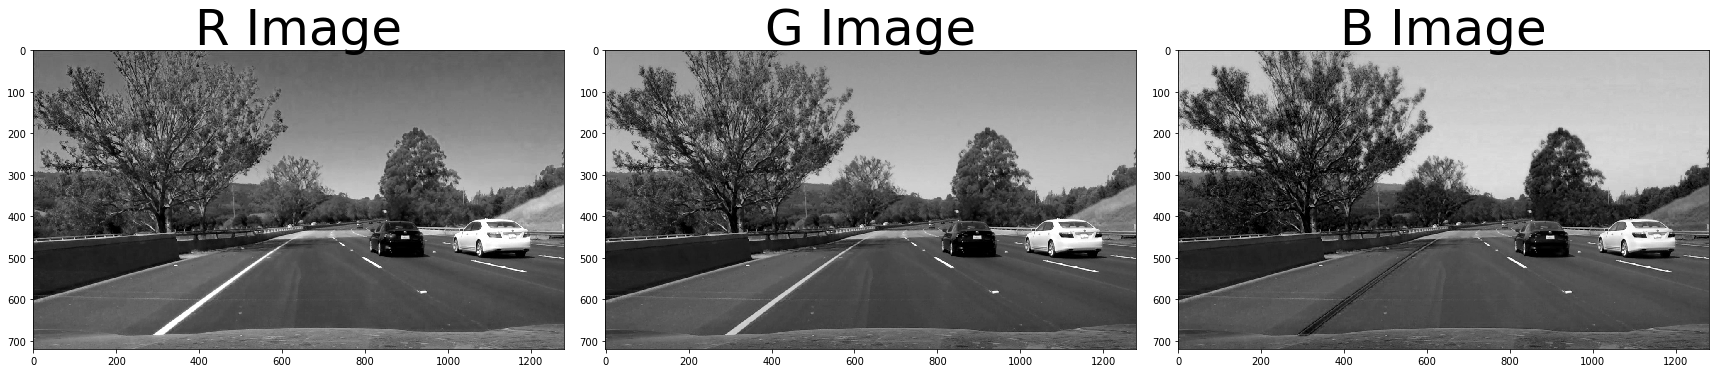

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.set_title('R Image', fontsize=50)
ax2.imshow(G, cmap='gray')
ax2.set_title('G Image', fontsize=50)
ax3.imshow(B, cmap='gray')
ax3.set_title('B Image', fontsize=50)

The R channel does a reasonable job of highlighting the lines, apply threshold to find lane-line pixel

In [10]:
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

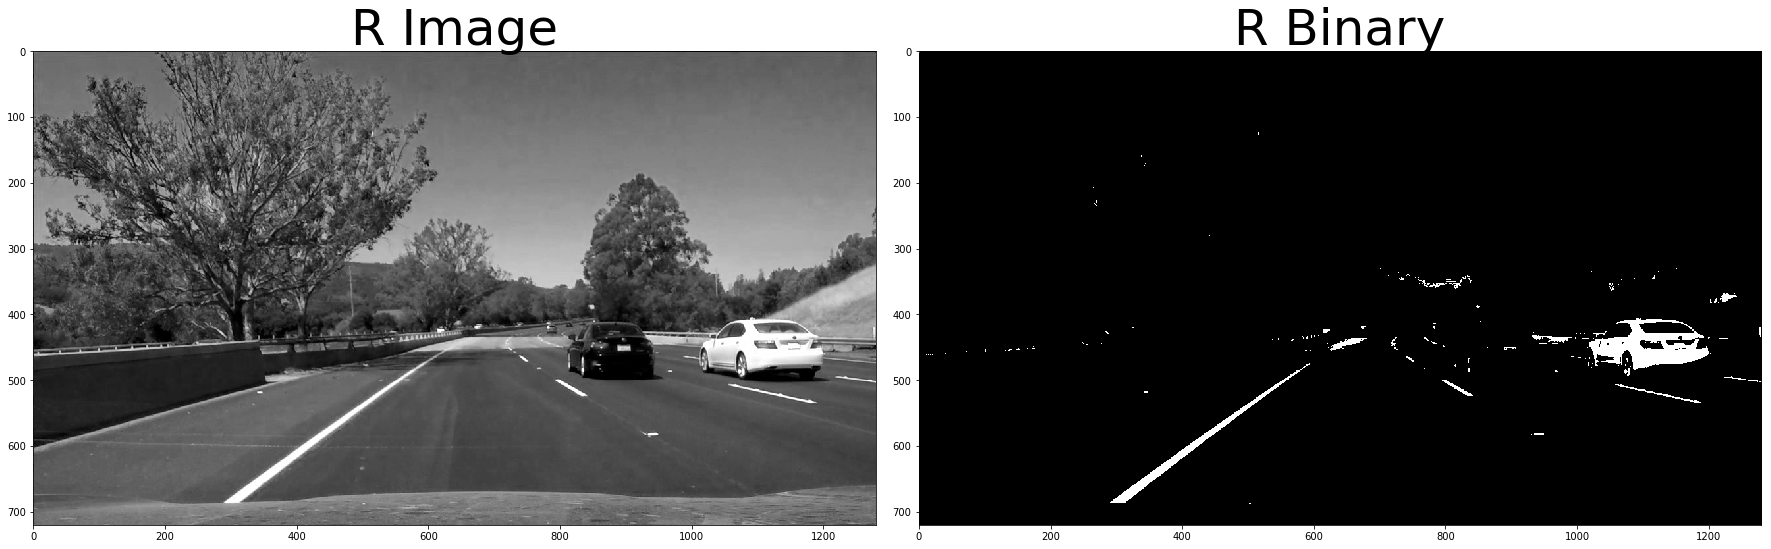

In [11]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.set_title('R Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('R Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### HLS color channels

In [13]:
# separate the H, L, and S channels
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

Text(0.5,1,'S Image')

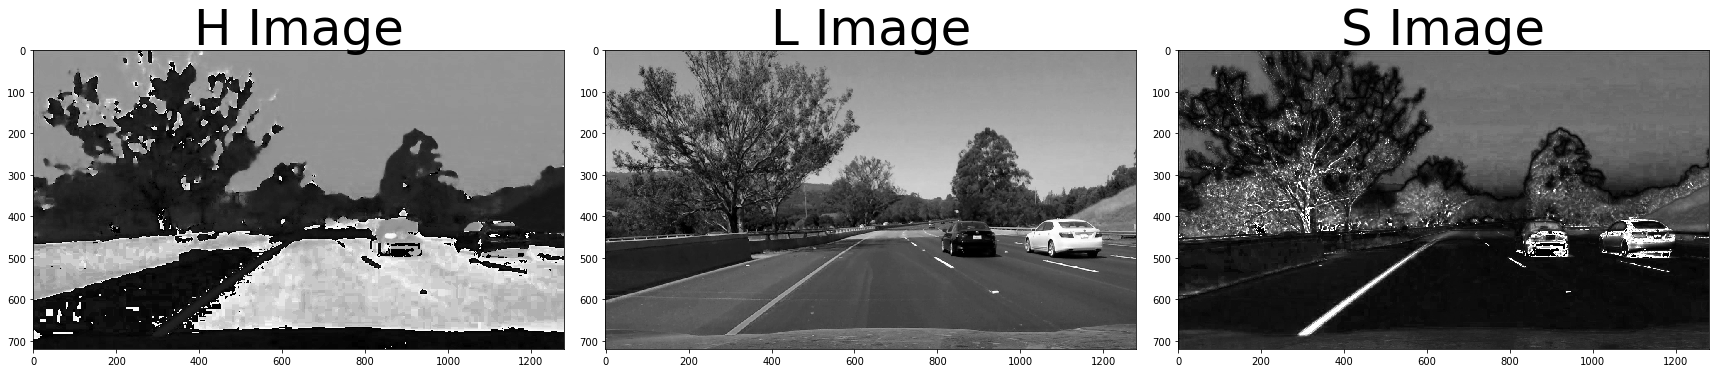

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H Image', fontsize=50)
ax2.imshow(L, cmap='gray')
ax2.set_title('L Image', fontsize=50)
ax3.imshow(S, cmap='gray')
ax3.set_title('S Image', fontsize=50)

S channel picks up the lines well, applying a threshold

In [15]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

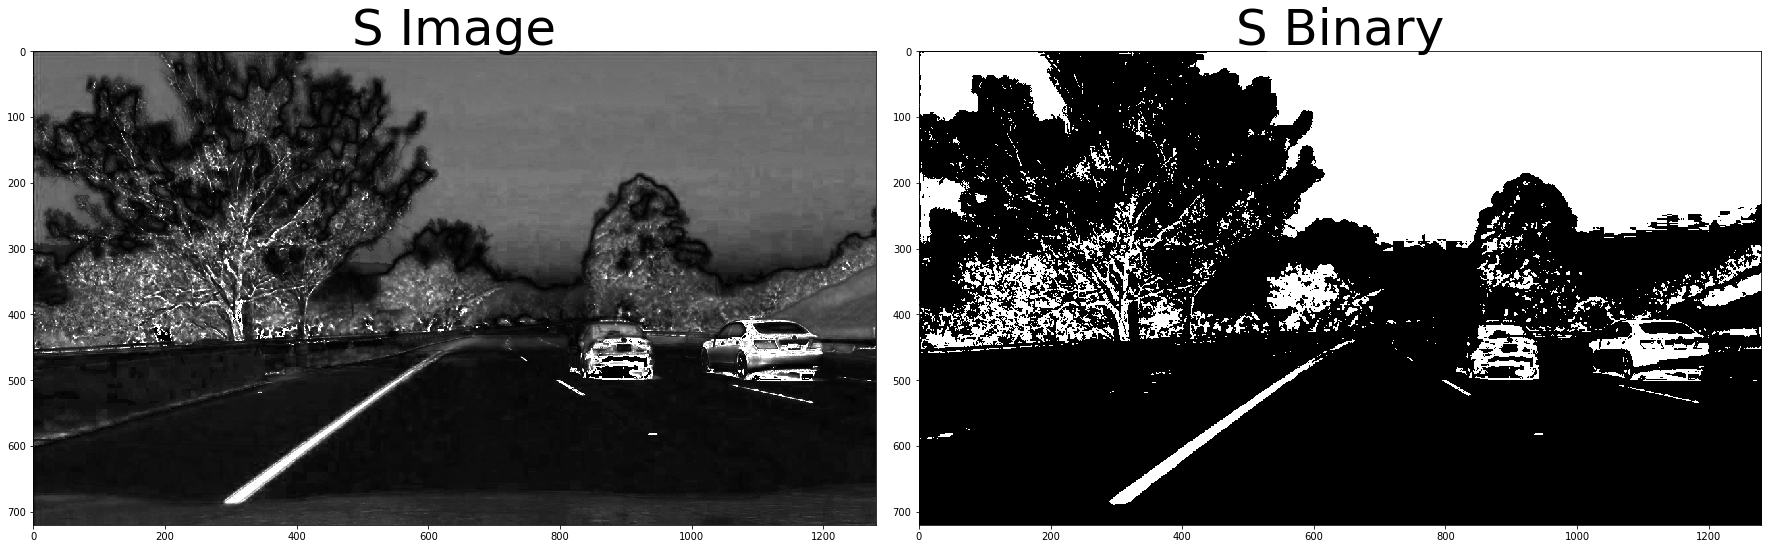

In [16]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S, cmap='gray')
ax1.set_title('S Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('S Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

H channel, the lane lines appear dark, so we try a low threshold there

In [17]:
thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

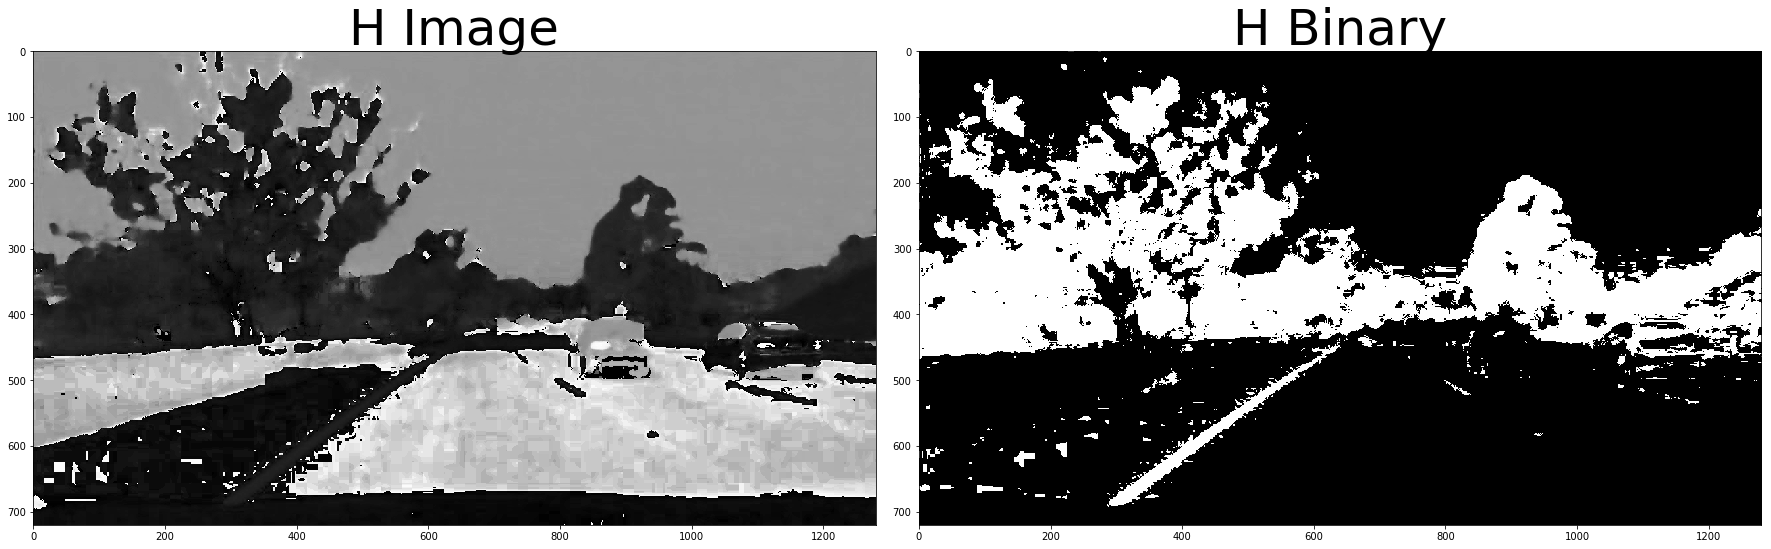

In [18]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('H Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Combining to a function

In [23]:
# function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

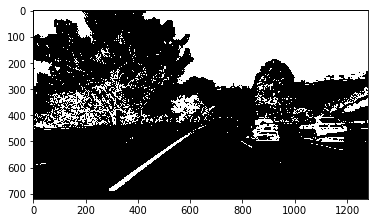

In [24]:
hls_binary = hls_select(image, thresh=(90, 255))
plt.imshow(hls_binary, cmap='gray')

### Combining Color and Gradient Thresholds

In [27]:
def ColorAndGradientThreshold(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary, color_binary

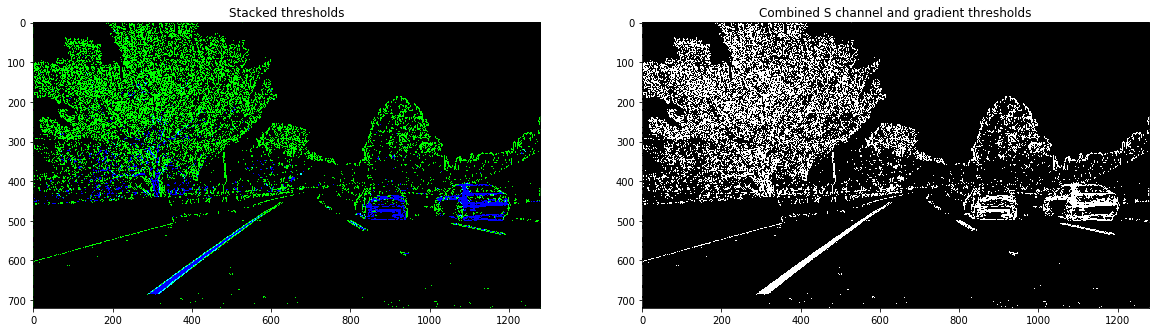

In [28]:
combined_binary, color_binary = ColorAndGradientThreshold(image)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [29]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

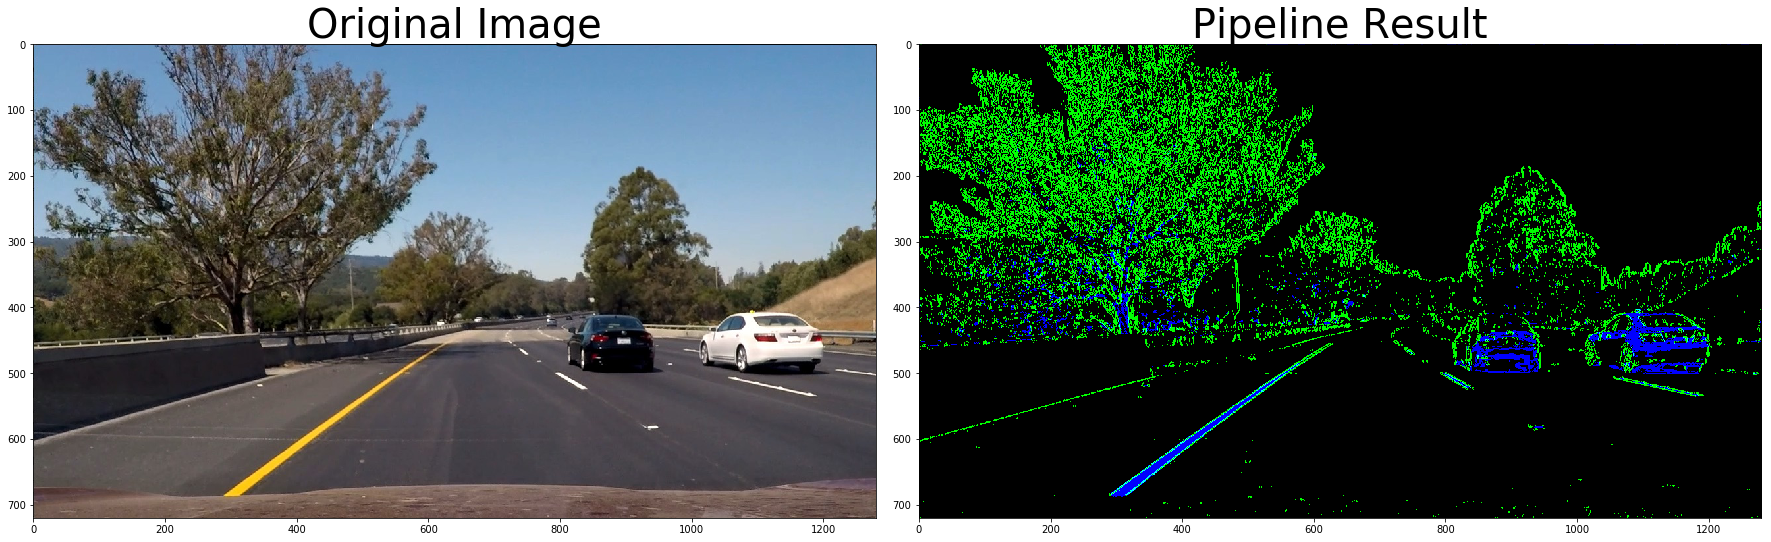

In [30]:
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)